In [1]:
import pandas as pd

# indiquer le chemin du fichier
chemin = "https://raw.githubusercontent.com/curiousML/DSA/master/text_mining/data/LA_TRANSITION_ECOLOGIQUE.csv"

# notre dataframe
raw_data = pd.read_csv(chemin, error_bad_lines=False, warn_bad_lines=False)

# filtre du dataset sur la colonne question
question = "Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?"
data = raw_data[question]

# suppression des nan
data = data[data.notnull()].to_frame()
data = data.rename(columns={data.columns[0]:'docs'})

/tmp/ipykernel_8865/2984787914.py:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  raw_data = pd.read_csv(chemin, error_bad_lines=False, warn_bad_lines=False)
/tmp/ipykernel_8865/2984787914.py:7: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  raw_data = pd.read_csv(chemin, error_bad_lines=False, warn_bad_lines=False)
/tmp/ipykernel_8865/2984787914.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(chemin, error_bad_lines=False, warn_bad_lines=False)


# Embeddinbg

In [3]:
from sentence_transformers import SentenceTransformer, util
import os

os.environ['CUDA_LAUNCH_BLOCKING']= 'True'

model = SentenceTransformer('dangvantuan/sentence-camembert-base')

ls_embeddings = model.encode(data['docs'].tolist())  #docs.apply(lambda x: laser.embed_sentences(x, lang='fr')[0])

#data.head()

# Cluster

In [4]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(ls_embeddings)

In [5]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(ls_embeddings)

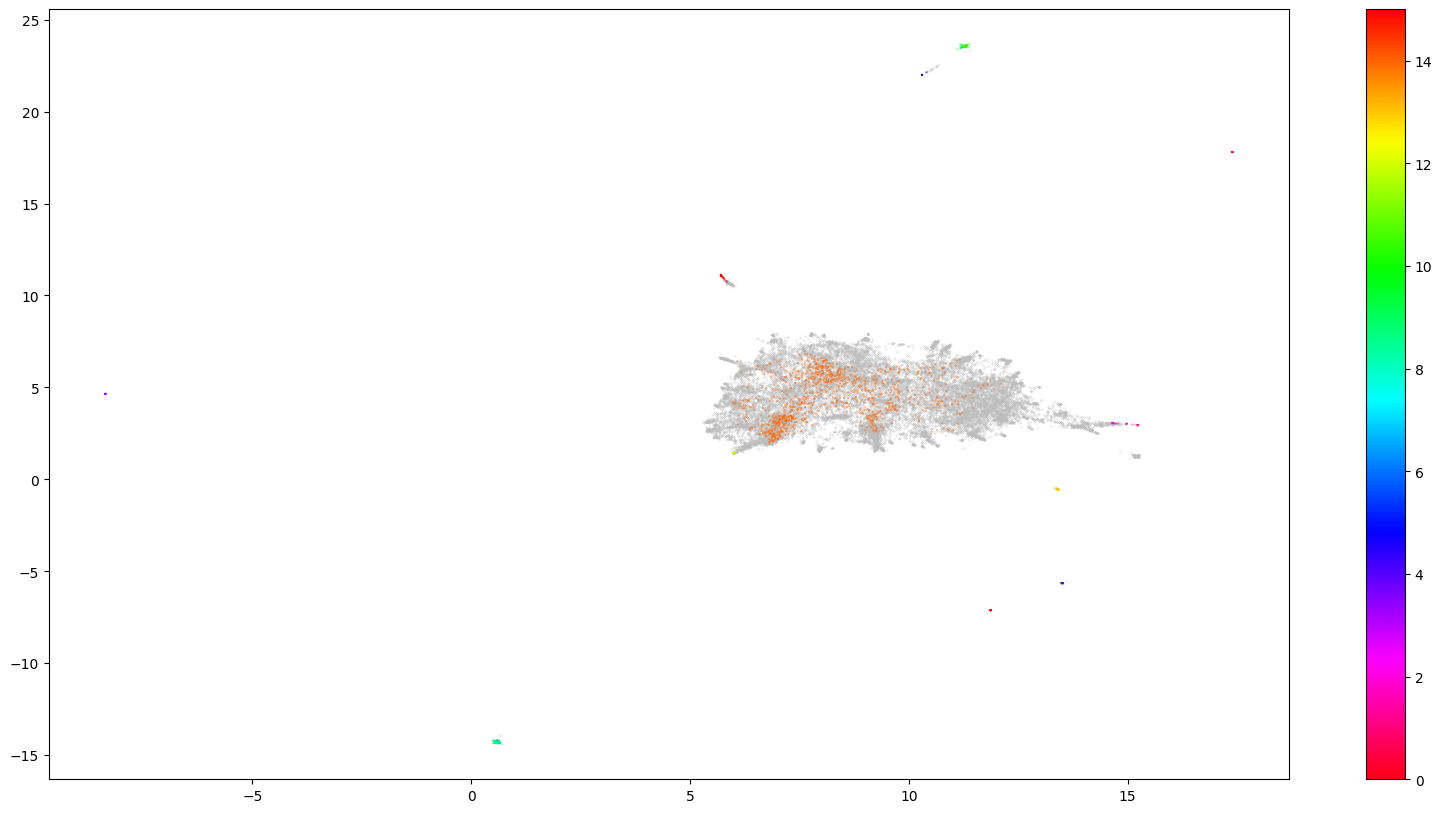

In [6]:
import matplotlib.pyplot as plt 

umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(ls_embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [7]:
docs_df = pd.DataFrame(data['docs'], columns=["docs"])
docs_df['topic'] = cluster.labels_
docs_df['doc_id'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['topic'], as_index = False).agg({'docs': ' '.join})

In [8]:
docs_per_topic

,topic,docs
0,-1,Multiplier les centrales géothermiques Les pro...
1,0,NON NON NON NON NON NON OUI NON NON NON NON NO...
2,1,Non. Oui. Non. Non. Non. Non. Oui. Oui. Non. N...
3,2,RAS Décroissance NC Néant Pleins Néant RIC RAS...
4,3,oui oui oui oui oui oui ... oui oui oui oui ou...
5,4,- 22 • - - - / / _ - - / - X - / - - / - / / - -
6,5,Oui Oui Oui Oui Oui Oui Oui tous Oui Oui Oui t...
7,6,non non non non non non non non non non non no...
8,7,Non Non Non Non Non Non Non Non Non Non Non No...
9,8,non non non non non non non non non non non no...


In [12]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer().fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(embeddings))

In [13]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "doc": "size"}, axis='columns')
                     .sort_values("size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/home/quentin/Documents/projet/perso/nlp_reviews_29220905/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
1,0,1289
0,-1,935
2,1,418
3,2,23


In [14]:
for i in top_n_words:
    print(i[:5])

[('client', 0.12115801469743419),
 ('service', 0.10533847604475678),
 ('réactif', 0.09327779578685293),
 ('efficace', 0.08438461701776812),
 ('rapide', 0.07829775629822291),
 ('rapider', 0.05949509022266405),
 ('prix', 0.05877628825517071),
 ('top', 0.05691926733584872),
 ('respect', 0.05302347776327141),
 ('impeccable', 0.0485868672241622),
 ('etour', 0.046952138908333),
 ('rigoureusemer', 0.046952138908333),
 ('servce', 0.046952138908333),
 ('employeur', 0.046952138908333),
 ('excellent', 0.043848413300106893),
 ('merite', 0.042826262833571424),
 ('livraison', 0.04120355826095718),
 ('résoud', 0.038700386758809845),
 ('plan', 0.0373721513343205),
 ('problem', 0.0373721513343205)]